# Lending Club Case Study

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
from warnings import filterwarnings

In [98]:
filterwarnings("ignore")
#supress scientific notation of values
# pd.options.display.float_format = '{:.2f}'.format

Custom functions

In [99]:
def remove_perc(val):
    try:
        val = val.replace("%","")
        return float(val)
    except AttributeError:
        #some values do not have percentage sign, thus there is no need to convert the value.
        new_val = float(val)
        return new_val


---

In [100]:
master = pd.read_csv("loan.csv")
print(master.shape)

(39717, 111)


In [101]:
#Finding percentage of null or missing values
null_perc = round(100*(master.isnull().sum()/len(master.index)), 2)
#Printing columns which have more than 0% missing values
null_perc[ null_perc > 0 ]

emp_title                      6.19
emp_length                     2.71
desc                          32.58
title                          0.03
mths_since_last_delinq        64.66
                              ...  
tax_liens                      0.10
tot_hi_cred_lim              100.00
total_bal_ex_mort            100.00
total_bc_limit               100.00
total_il_high_credit_limit   100.00
Length: 68, dtype: float64

As it can be seen that there are many columns, that have null values. Thus, I have run a separate analysis which resulted in the following columns being the only relevant features:

The features are only used after the loan has been approved and then the applicants are kept under monitoring.

List of post-approval features: <br>
- delinq_2yrs
- revol_bal
- out_prncp
- total_pymnt
- total_rec_prncp
- total_rec_int
- total_rec_late_fee
- recoveries
- collection_recovery_fee
- last_pymnt_d
- last_pymnt_amnt
- next_pymnt_d
- chargeoff_within_12_mths
- mths_since_last_delinq
- mths_since_last_record


In [102]:
cols_use = ["id","loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade",
"emp_title","emp_length","home_ownership","annual_inc","verification_status","issue_d","loan_status","pymnt_plan",
"desc","purpose","title","addr_state","dti","earliest_cr_line","delinq_2yrs","earliest_cr_line","inq_last_6mths",
"mths_since_last_delinq","mths_since_last_record","open_acc","pub_rec","revol_bal","revol_util","total_acc","initial_list_status",
"out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee",
"recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt","next_pymnt_d","last_credit_pull_d",
"collections_12_mths_ex_med","mths_since_last_major_derog","policy_code","application_type"]

In [103]:
master = pd.read_csv("loan.csv",usecols=cols_use)
master.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,1077501,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,NaN,...,0.00,0.00,Jan-15,171.62,NaN,May-16,0.00,NaN,1,INDIVIDUAL
1,1077430,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,Ryder,...,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.00,NaN,1,INDIVIDUAL
2,1077175,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,NaN,...,0.00,0.00,Jun-14,649.91,NaN,May-16,0.00,NaN,1,INDIVIDUAL
3,1076863,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,...,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.00,NaN,1,INDIVIDUAL
4,1075358,3000,3000,3000.00,60 months,12.69%,67.79,B,B5,University Medical Group,...,0.00,0.00,May-16,67.79,Jun-16,May-16,0.00,NaN,1,INDIVIDUAL


In [104]:
charged_off = master[master["loan_status"] == "Charged Off"]
charged_off.shape

(5627, 50)

## Cleaning the dataset:

In [105]:
# Interest rate:
# Removing the percentage sign and converting to float.
master["int_rate"] = master["int_rate"].apply(remove_perc)

In [106]:
# Replacing the Abbreviation of State with their complete names:
with open("State_abbr.json","r") as f:
    states = load(f)

master["addr_state"] = master["addr_state"].replace(states)


In [107]:
# Revolving Utlity - Removing percentage sign.
master["revol_util"] = master["revol_util"].apply(remove_perc)
# master["revol_util"] = master["revol_util"].apply(lambda x:float(x))

In [108]:
## Home Ownership has 3 NONE values, so it is better to combine it with "OTHER" for analysis:
master["home_ownership"] = master["home_ownership"].replace("NONE","OTHER")

In [109]:
# Removing Extra white space.
master['term'] = master.term.str.strip()
master.term.unique()

array(['36 months', '60 months'], dtype=object)

In [110]:
# Converting appropriate columns to Date type
master["issue_d"] = pd.to_datetime(master["issue_d"],format='%b-%y')
master['issue_d'] = master['issue_d'].apply(lambda x: x-pd.DateOffset(years=100) if x.year > 2020 else x)

master['earliest_cr_line'] = pd.to_datetime(master.earliest_cr_line, format='%b-%y')
master['earliest_cr_line'] = master['earliest_cr_line'].apply(lambda x: x-pd.DateOffset(years=100) if x.year > 2020 else x)

#### Derived Columns:

In [111]:
# Year and Month for Issue Data and Earliest Credit Line.

master["issue_d_year"] = master["issue_d"].dt.year
master["issue_d_month"] = master["issue_d"].dt.strftime('%b')

master["earliest_cr_line_year"] = master["earliest_cr_line"].dt.year
master["earliest_cr_line_month"] = master["earliest_cr_line"].dt.strftime('%b')

In [112]:
#Funded amount Ratio
master["fund_amnt_ratio"] = master['approved_loan_amnt_ratio'] = round(master.funded_amnt_inv*100/master.loan_amnt,2)

### Univariate Analysis

**Loan Amount**

count   39717.00
mean    11219.44
std      7456.67
min       500.00
5%       2400.00
10%      3200.00
25%      5500.00
50%     10000.00
75%     15000.00
90%     22000.00
95%     25000.00
99%     35000.00
max     35000.00
Name: loan_amnt, dtype: float64


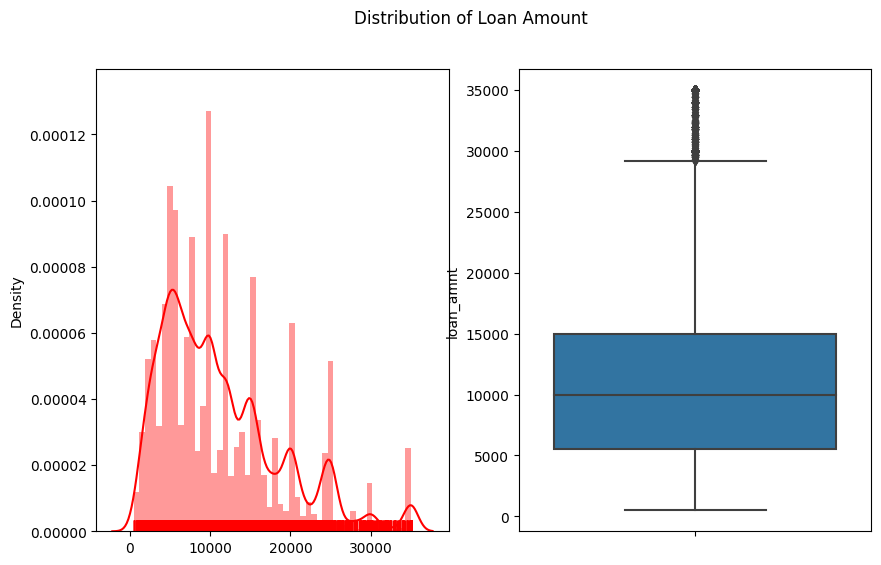

In [113]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
plt.suptitle("Distribution of Loan Amount")
sns.distplot(ax=ax[0],x=master["loan_amnt"],color='red',rug=True);
sns.boxplot(ax=ax[1],y=master["loan_amnt"]);

print(master["loan_amnt"].describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]))

It can be seen that majority of the loans that are given are in the range of $5000 to $15000 with only a minor amount of loans going beyond $35000.

---


**Funded Amount**:

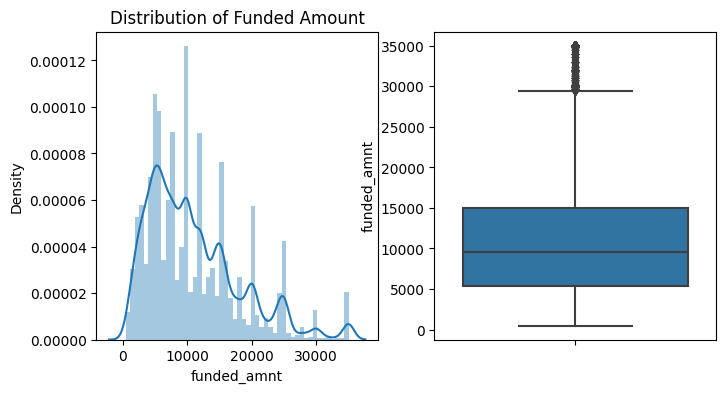

In [114]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].set_title("Distribution of Funded Amount")
sns.distplot(ax=ax[0],a=master["funded_amnt"])

sns.boxplot(ax=ax[1],y=master["funded_amnt"]);

*Observation*: <br>
Funded Amount is similar to the Loan amount of curve which indicates that Lending Club has approved most of the applicants.

**Amount Funded by investors** : <br>
The part of loan amount funded by investors.

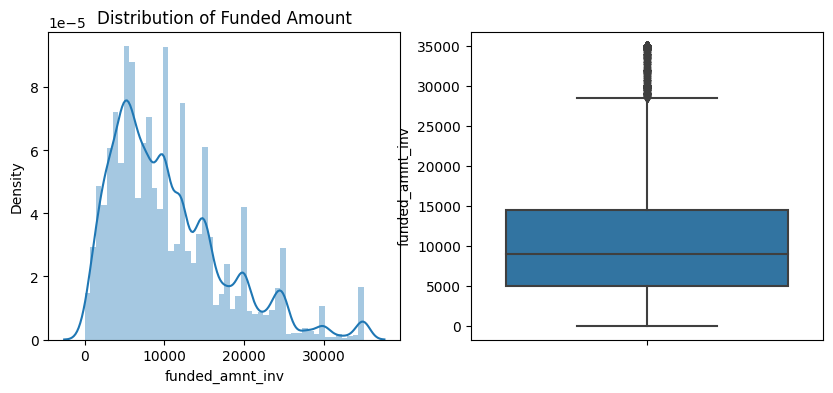

In [115]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].set_title("Distribution of Funded Amount")
sns.distplot(ax=ax[0],a=master["funded_amnt_inv"])

sns.boxplot(ax=ax[1],y=master["funded_amnt_inv"]);

*Observation*: <br>
Investors' funded amount behaves similar to the Loan amount. Which means Investors agreed to fund most of the applicants. 

**Approved Loan Amount ratio**: <br>
This is to compare the ratio of the money funded by investors and Lending Club.

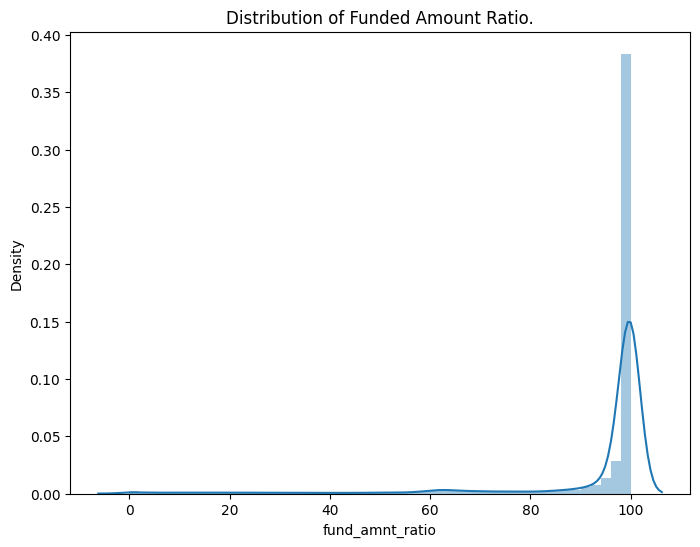

In [116]:
plt.figure(figsize=(8,6))
plt.title("Distribution of Funded Amount Ratio.")
sns.distplot(a=master["fund_amnt_ratio"]);

*Observation*: <br>
Investors fund majority of the total Loan amount. The ratio funded by investors could be anywhere between 80% to 100%.

**Interest Rate** 

In [117]:
master['int_rate'].dtype

dtype('float64')

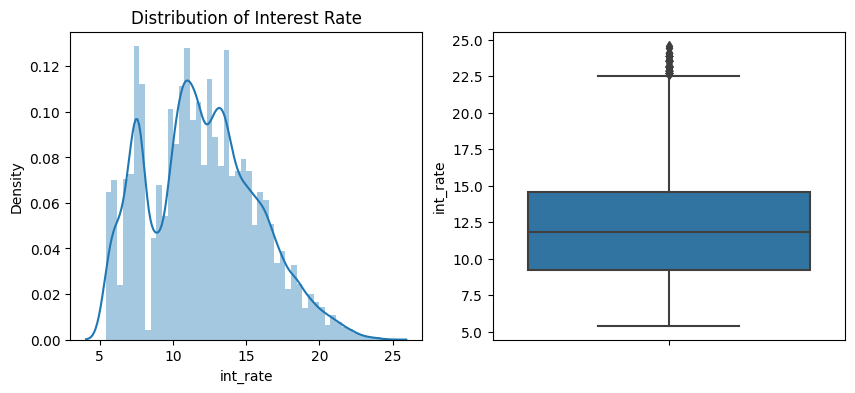

In [118]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].set_title("Distribution of Interest Rate")
sns.distplot(ax=ax[0],a=master["int_rate"])

sns.boxplot(ax=ax[1],y=master["int_rate"]);

**Observation**: <Br>
Most of the interest rates lie between <b>9% to 15%</b>. Some loans were granted at high rates of more than **20%** .

**Annual Income**: <br>
Self reported annual income of the applicant

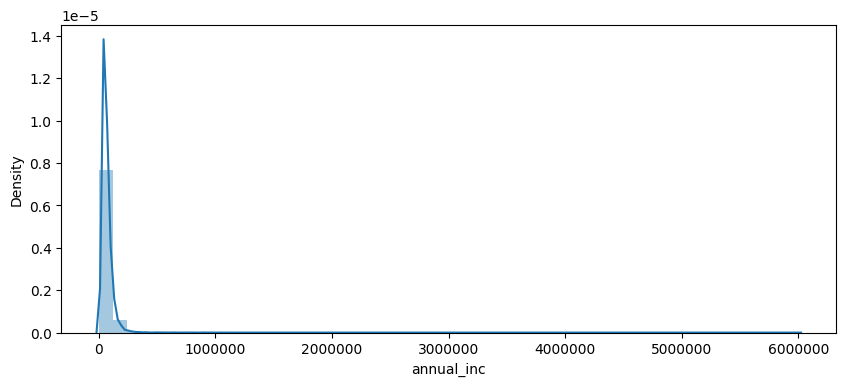

In [142]:
plt.figure(figsize=(10,4))
plt.ticklabel_format(axis='x',style='plain')
sns.distplot(a=master["annual_inc"])
plt.show();

**Loan Issue Date**

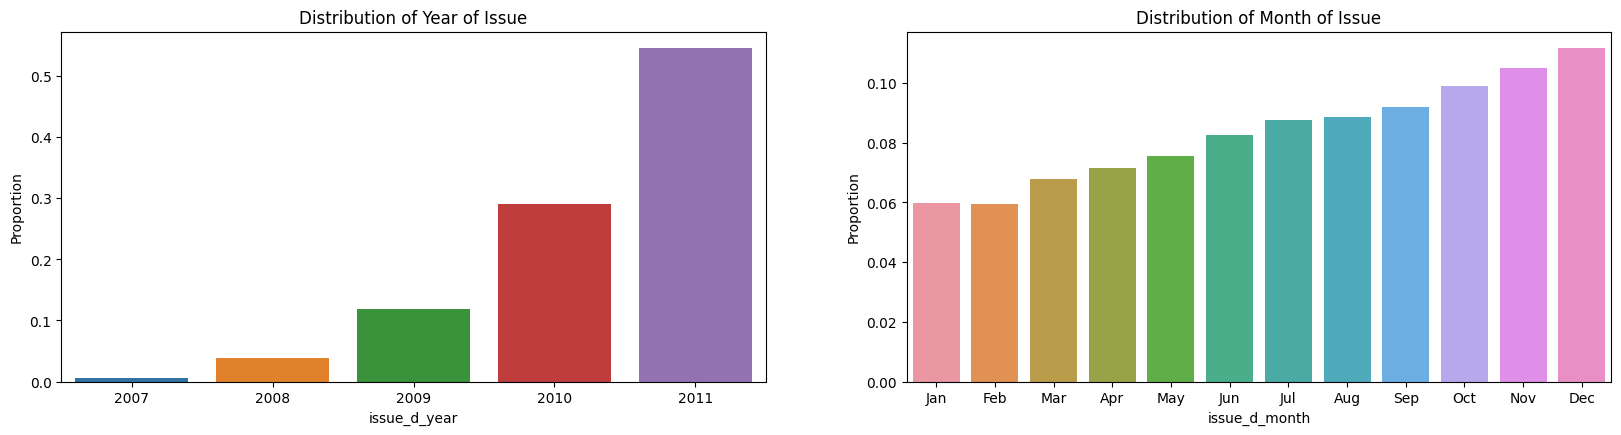

In [149]:
var = "issue_d_year"

# Percentage of each values:
perc_df = master[var].value_counts(normalize=True).reset_index()

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.barplot(x='index', y=var, data=perc_df)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title('Distribution of Year of Issue')

var = 'issue_d_month'
months = ["Jan","Feb","Mar","Apr","May",'Jun',"Jul","Aug","Sep","Oct",'Nov',"Dec"]
#Percentage of each value
perc_df = master[var].value_counts(normalize=True).reset_index()
plt.subplot(2,2,2)
sns.barplot(x='index', y=var, data=perc_df,order=months)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title('Distribution of Month of Issue')

plt.show();

*Observation*: <br>
The number of loans issued increased drastically in the years 2010 and 2011. This also matches with the recovery period after 2008 financial crisis triggered by the Lehman brothers.

**Earliest Credit Line**

### Exploring the Categorical Variables

#### Grade and Subgrades
The details of the Grades and Subgrades of the loans can be found here : <br>

https://www.lendingclub.com/foliofn/rateDetail.action <br>

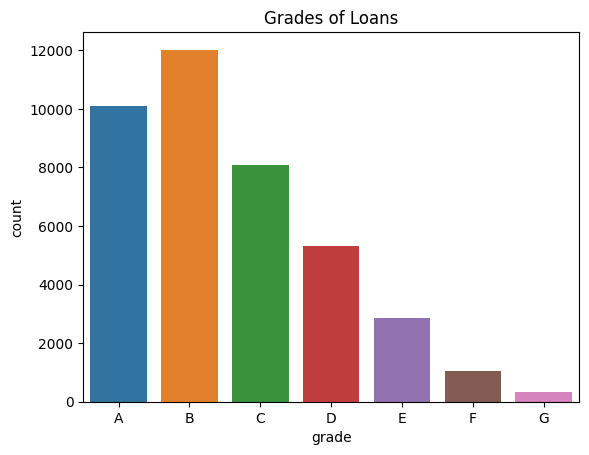

In [120]:
grades = master["grade"]
plt.title("Grades of Loans")
sns.countplot(grades,order=["A","B","C","D","E","F","G"]);

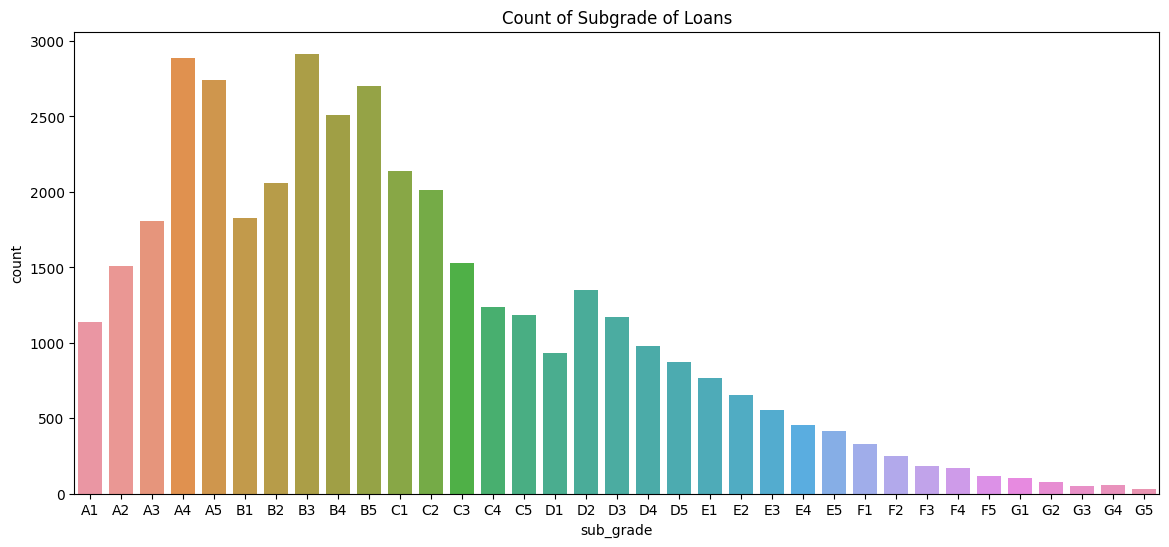

In [121]:
subgrade = master["sub_grade"]
subgrade.value_counts()
order = sorted(subgrade.value_counts().index)
plt.figure(figsize=(14,6))
plt.title("Count of Subgrade of Loans")
sns.countplot(subgrade,order=order);

As per the link above, B grade loans have a interest rate of <b>13.33%</b> to **16.08%** <i>(as of 7th Sep 2022)</i>.

#### Home Ownership:

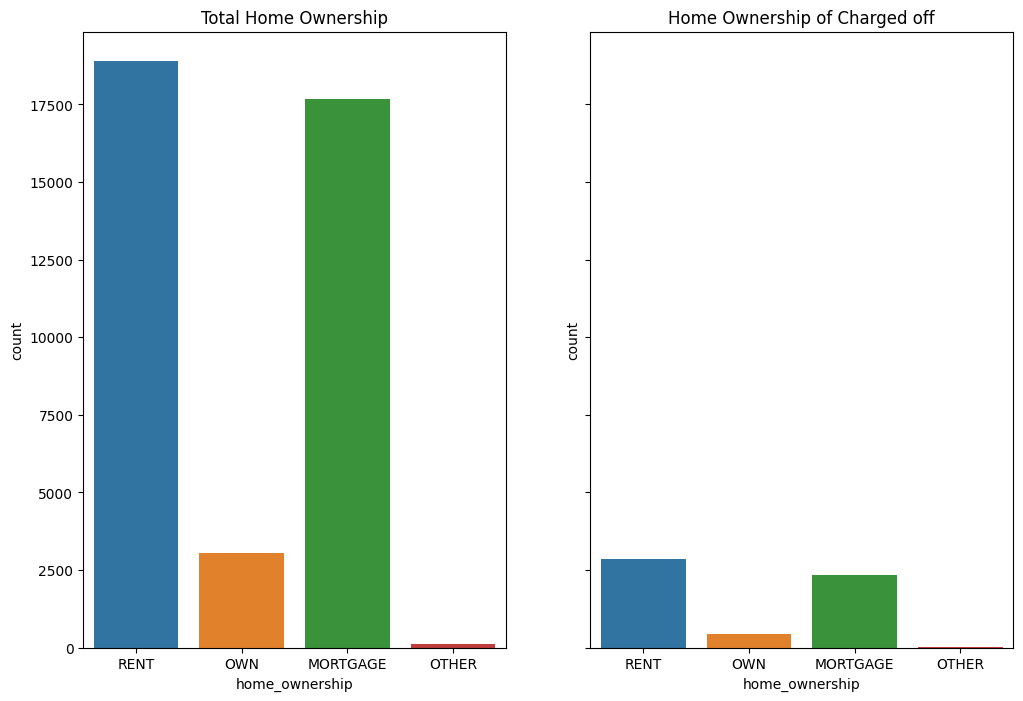

In [122]:
fig, ax = plt.subplots(1,2,figsize=(12,8),sharey=True)
ax[0].set_title("Total Home Ownership")
sns.countplot(ax=ax[0],x=master["home_ownership"]);

ax[1].set_title("Home Ownership of Charged off")
sns.countplot(ax=ax[1],x=charged_off["home_ownership"]);


<h4> Inference </h4>:  <br>
In both the cases, the people who rent and mortgage their homes take a lot of loans. Even amongst the defaulters, the renters and mortgages are the risky ones. 

### Purpose

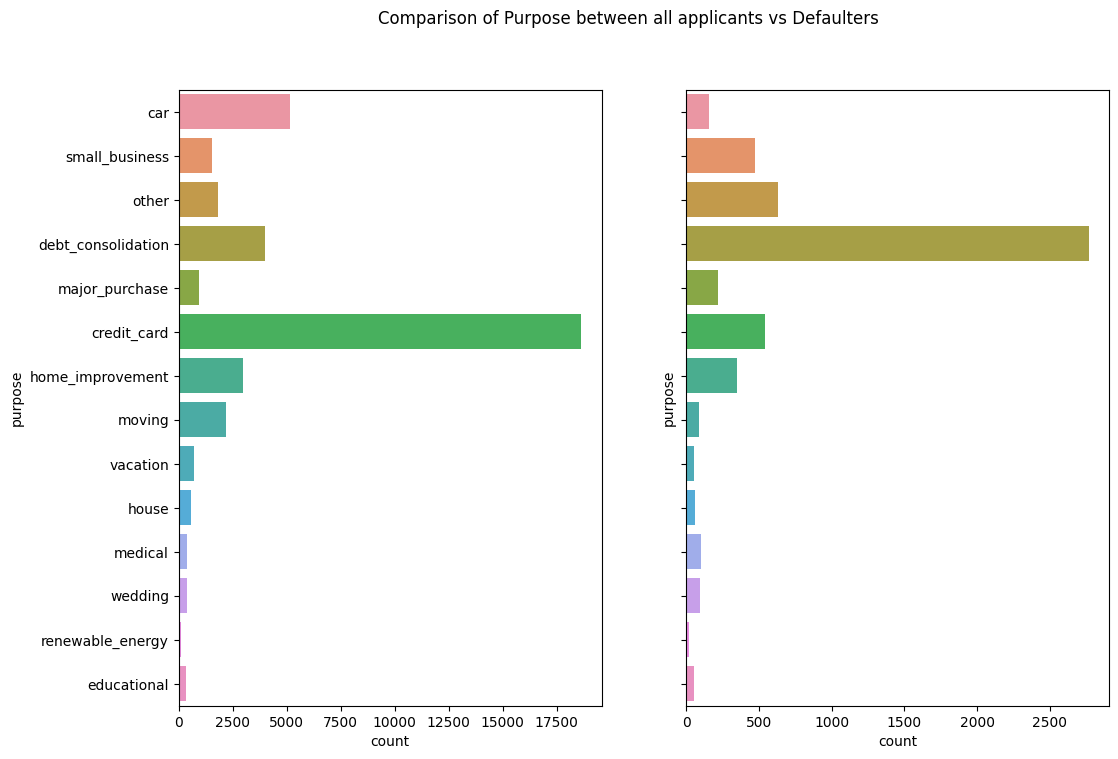

In [123]:
fig, ax = plt.subplots(1,2,figsize = (12,8),sharey=True)
plt.suptitle("Comparison of Purpose between all applicants vs Defaulters")
sns.countplot(ax=ax[0], y ='purpose', data=master)
sns.countplot(ax=ax[1], y ='purpose', data=charged_off)
plt.show();


#### Inference:


States  

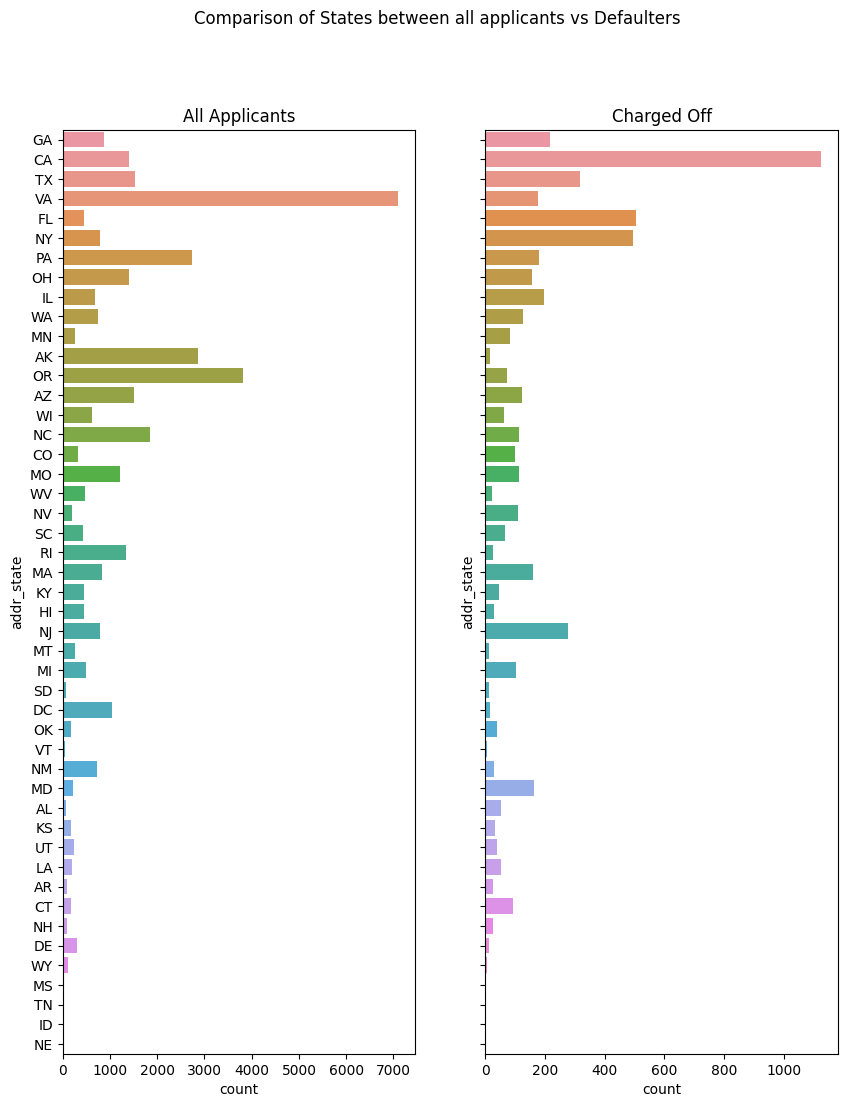

In [124]:
## States
fig, ax = plt.subplots(1,2,figsize = (10,12),sharey=True)
plt.suptitle("Comparison of States between all applicants vs Defaulters")
ax[0].set_title("All Applicants")
sns.countplot(ax=ax[0], y ='addr_state', data=master)

ax[1].set_title("Charged Off")
sns.countplot(ax=ax[1], y ='addr_state', data=charged_off)
plt.show();


### Segmented Univariate Analysis:

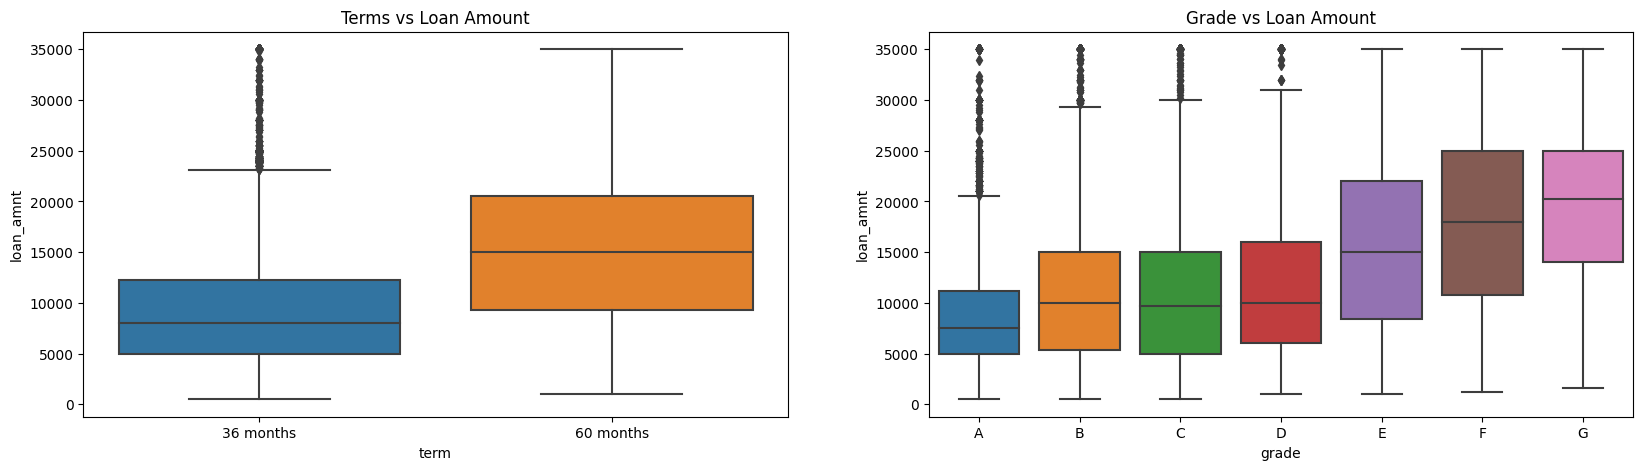

In [125]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
sns.boxplot(x='term', y=master.loan_amnt, data=master)
plt.title('Terms vs Loan Amount')
plt.subplot(122)
plt.title('Grade vs Loan Amount')
# Finding grades with sorted alphabetical order
grade_ord = master.grade.unique()
grade_ord.sort()
sns.boxplot(x='grade', y=master.loan_amnt, order=grade_ord, data=master);


<b>Inference</b>: <br>

High amount loans tend to have a high tenure i.e, 60 months. This is expected as borrowers are given ample time to return the loan. <br>

As per the link  - https://www.lendingclub.com/foliofn/rateDetail.action , grade G refers to high interest loans. Lending Club uses high interest rate on bigger loans to  reduce defaulting. 


Home Ownership vs Loan Amount:

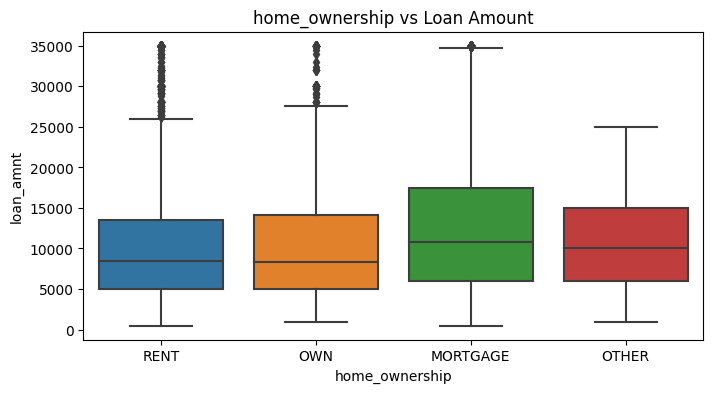

In [126]:
plt.figure(figsize=(8,4))
plt.title('home_ownership vs Loan Amount')
sns.boxplot(x='home_ownership', y=master.loan_amnt, data=master);


<b>Observations</b>:

Mortgage owners tend to have a lower appetite for loans, as the number of outliers is far lower than those of Rent and Owned. This is expected as they are already mortgaged and thus are unlikely to receive high loan amount due to lack of collateral. <br>
On the other hand, renters and owners have a higher appetite for loans, thus can take large amounts. 

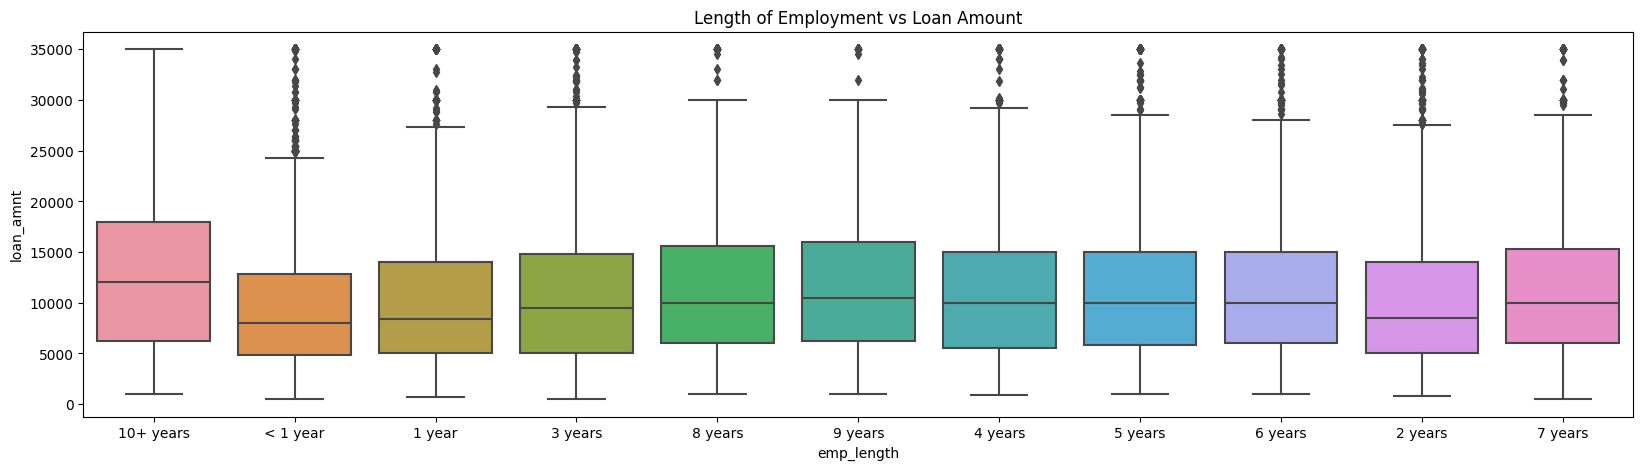

In [127]:
plt.figure(figsize=(20,5))
plt.title('Length of Employment vs Loan Amount')
sns.boxplot(x='emp_length', y=master.loan_amnt, data=master);


In [128]:
master["emp_length"].value_counts()

10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: emp_length, dtype: int64

<b>Observations</b>: <br>

People with more than 10+ years of employment tend to take higher amount of loans.

### Bivariate Analysis

Term vs Loan Status

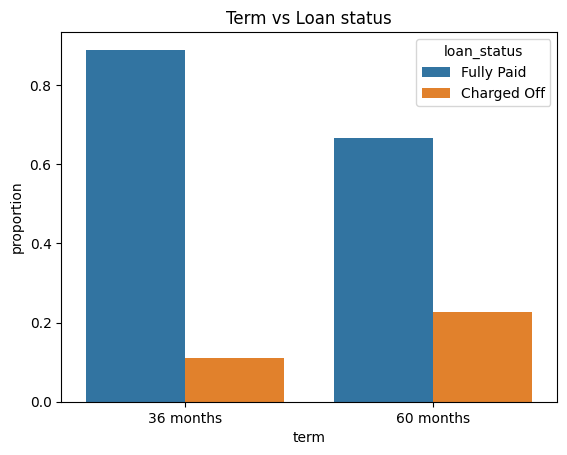

In [129]:
#Proportion of values for each category
df = master.groupby(['term', 'loan_status'], as_index=False)['id'].count()
df['proportion'] = df.groupby('term').transform(lambda x: x/x.sum())
plt.title('Term vs Loan status')
sns.barplot(x='term', y='proportion', hue='loan_status', data=df, hue_order = ['Fully Paid', 'Charged Off']);


<b>Observation</b>: <br>
- The number of defaulters are more for the loans with 60 months payback period.
- The loans with 36 months have higher pay-off rate than that of 60 months. This is expected as loans with smaller amounts have shorter time period and is easier to payback